In [1]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import seaborn as sns
import numpy as np 
import scipy.stats as ss
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
import json
%matplotlib inline

home_path = os.environ['HOME']

with open(home_path+'/dbCred/home_db_crd.json') as f:
    cred = json.load(f)

conn = pg.connect(database=cred['database'], user=cred['user'], password=cred['password'], 
                  host=cred['host'], port=cred['port'])


In [14]:
sql = """select * from oodle_data"""
df = pd.read_sql(sql, conn)
df['id'] = df['id'].astype(int)
df['age'] = df['age'].astype(int)
df.head(10)

,id,age,car_type,loan_amount,deposit,area,apr,application_outcome,funded
0,9997,61,Convertible,"£24,108.00",£881.00,rural,0.15,approved,No
1,9996,42,Saloon,"£5,988.00",£967.00,rural,0.2,approved,No
2,9995,57,Saloon,"£5,099.00",£973.00,urban,0.15,approved,No
3,9994,32,Convertible,"£20,774.00","£1,478.00",rural,NA,declined,NA
4,9993,29,Saloon,"£4,612.00",£774.00,urban,NA,declined,NA
5,9988,63,Saloon,"£2,980.00",£679.00,rural,NA,declined,NA
6,9985,49,SUV,"£9,738.00",£671.00,rural,0.15,approved,Yes
7,9981,52,Saloon,"£6,341.00",£533.00,urban,0.15,approved,No
8,9979,21,Convertible,"£18,056.00","£1,152.00",urban,NA,declined,NA
9,9978,19,SUV,"£14,884.00","£1,233.00",rural,NA,declined,NA


<font size="4">The table above gives an overview of the dataset.
><b>Age</b> : Age of the applicant <br/>
    <b>Car_type</b> : Type of car the loan application was for, one of Convertible, Saloon and SUV <br/>
    <b>Loanamount</b> : Loan amount applied for <br/>
    <b>Deposit</b> : Customer deposit <br/>
    <b>Area</b> : Based on the postcode of the applicant whether they live in an urban or rural area <br/>
 <b>APR</b> : APR on the loan <br/>
    <b>Application_outcome</b>: Whether the loan was approved or declined <br/>
    <b>Funded</b>: Whether the application approval converted into a funded loan

<b>Question</b> We would like you to help us understand which segments of our customers we need to invest
more in marketing based on the data provided. Your audience is technical leadership</font>

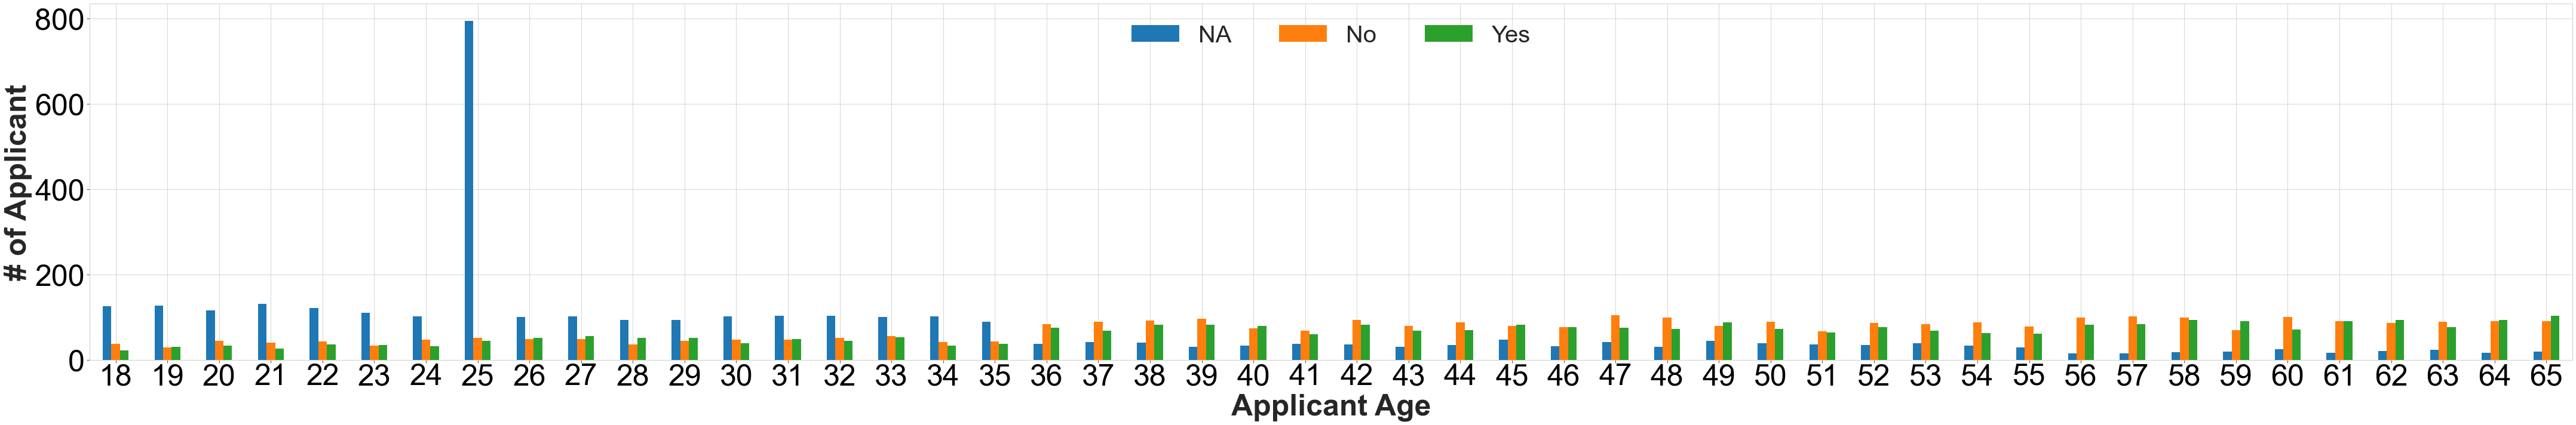

In [35]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
GROUP BY age, funded)a
order by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='num_applicant')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=40, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('# of Applicant', fontsize=50, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/dist_funded_stats_applicant_number.pdf",  bbox_inches="tight")

<font size="4">The graph above is computed by counting the number of applicant in each age group. Almost 800 applicants of age 25 had their loan application request declined.</font>

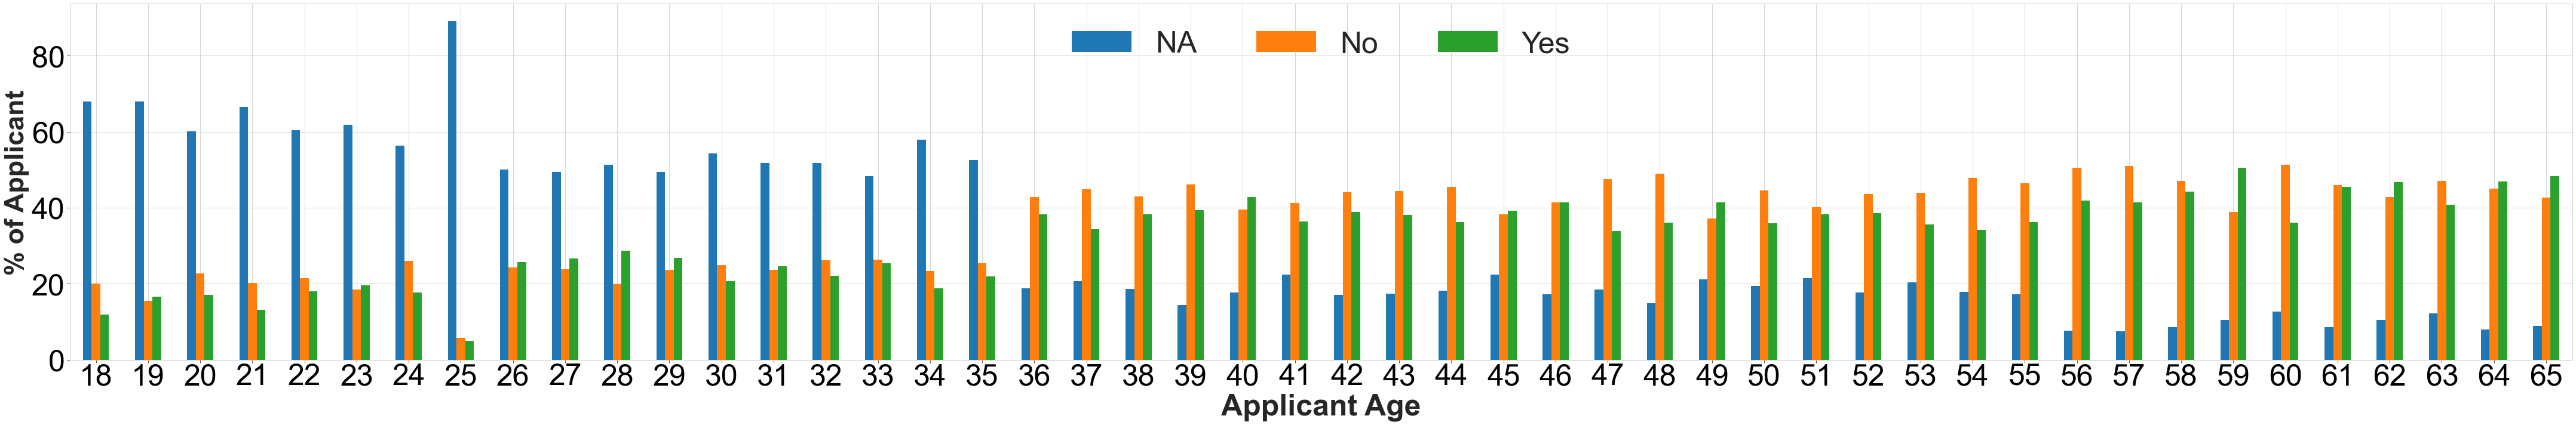

In [36]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
GROUP BY age, funded)a
order by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/dist_funded_stats_applicant_percent.pdf",  bbox_inches="tight")

<font size="4">Same as above but the metric on the Y-axis is computed on percentages. So, we compute the percentage distribution of loan application status for each age group.</font>

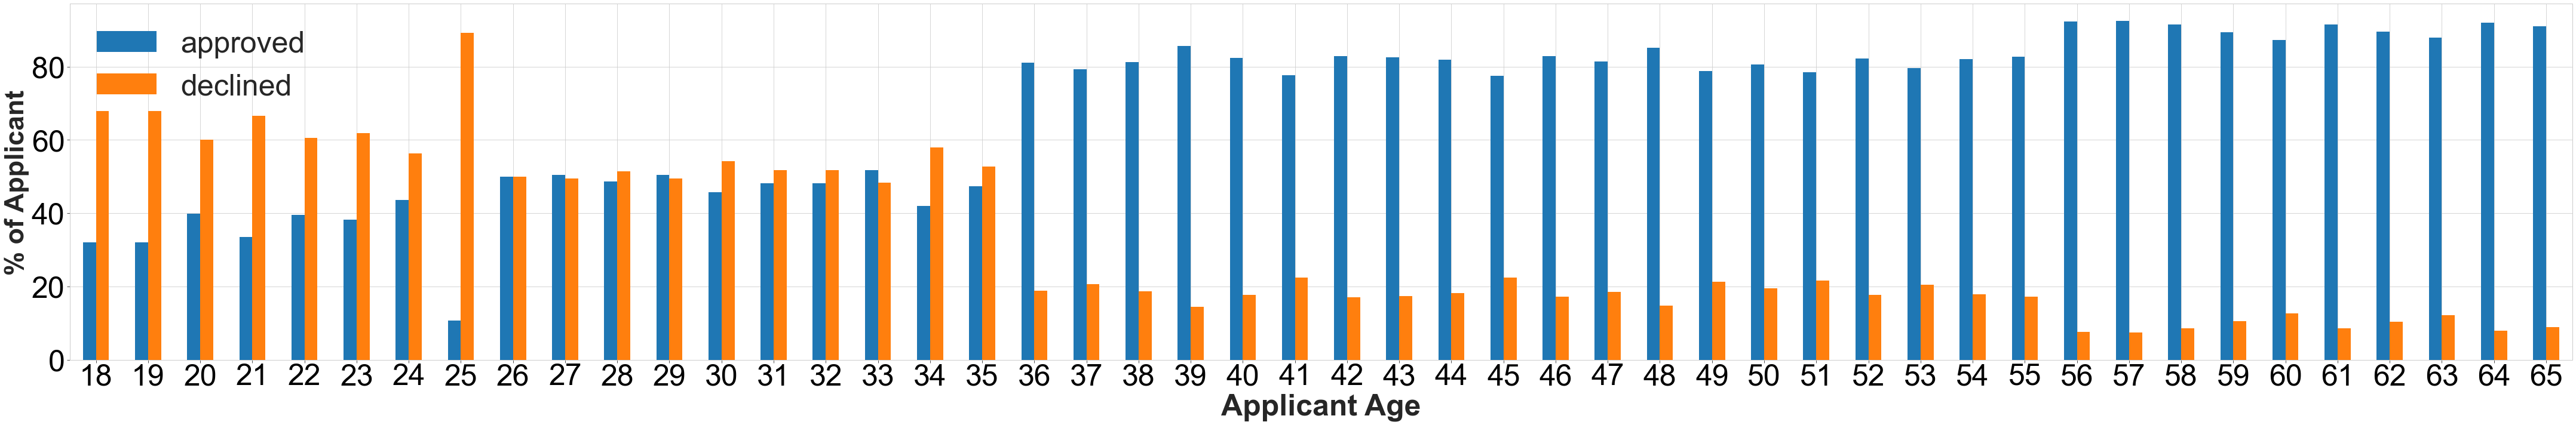

In [6]:
sql = """
select a.age, a.application_outcome, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, application_outcome ,count(id) num_applicant
from oodle_data
group by age, application_outcome)a
order  by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='application_outcome', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=1)

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_vs_declined_age_group.pdf",  bbox_inches="tight")

<font size="4">The figure above shows the percentage distribution of approved and declined loan applications across age. We see that most applicants betwen age 18-35 have their loan application declined compare to those between 36-65, with applicats of age 56 having the highest percentage (91%) of approved applications.</font>

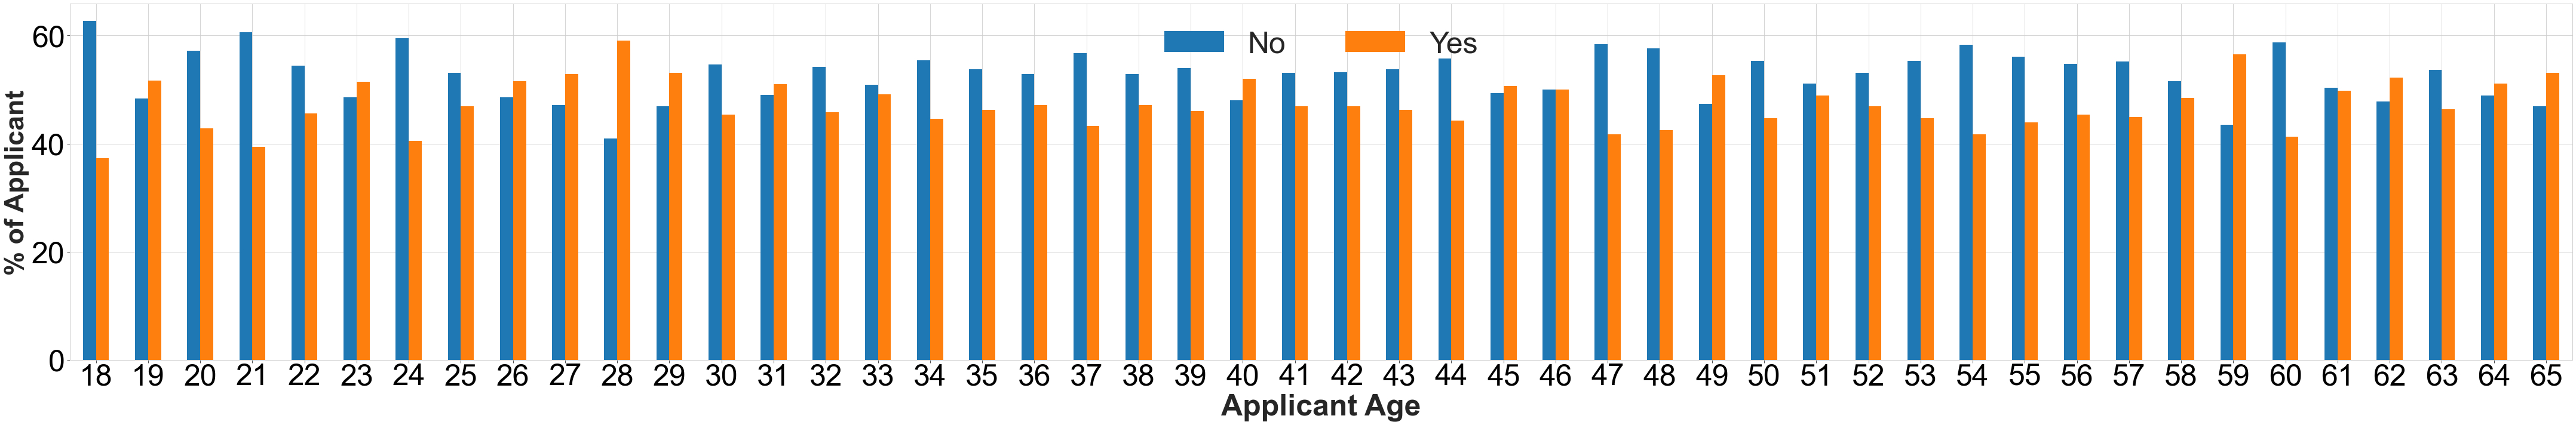

In [8]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, funded)a
order by 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_loans_funded_status.pdf",  bbox_inches="tight")

<font size="4">The figure above shows the percentage distribution of <b>approved</b> loan applications that are funded and not-funded across each age. We se that across most age approved loans are not disbursed.</font>

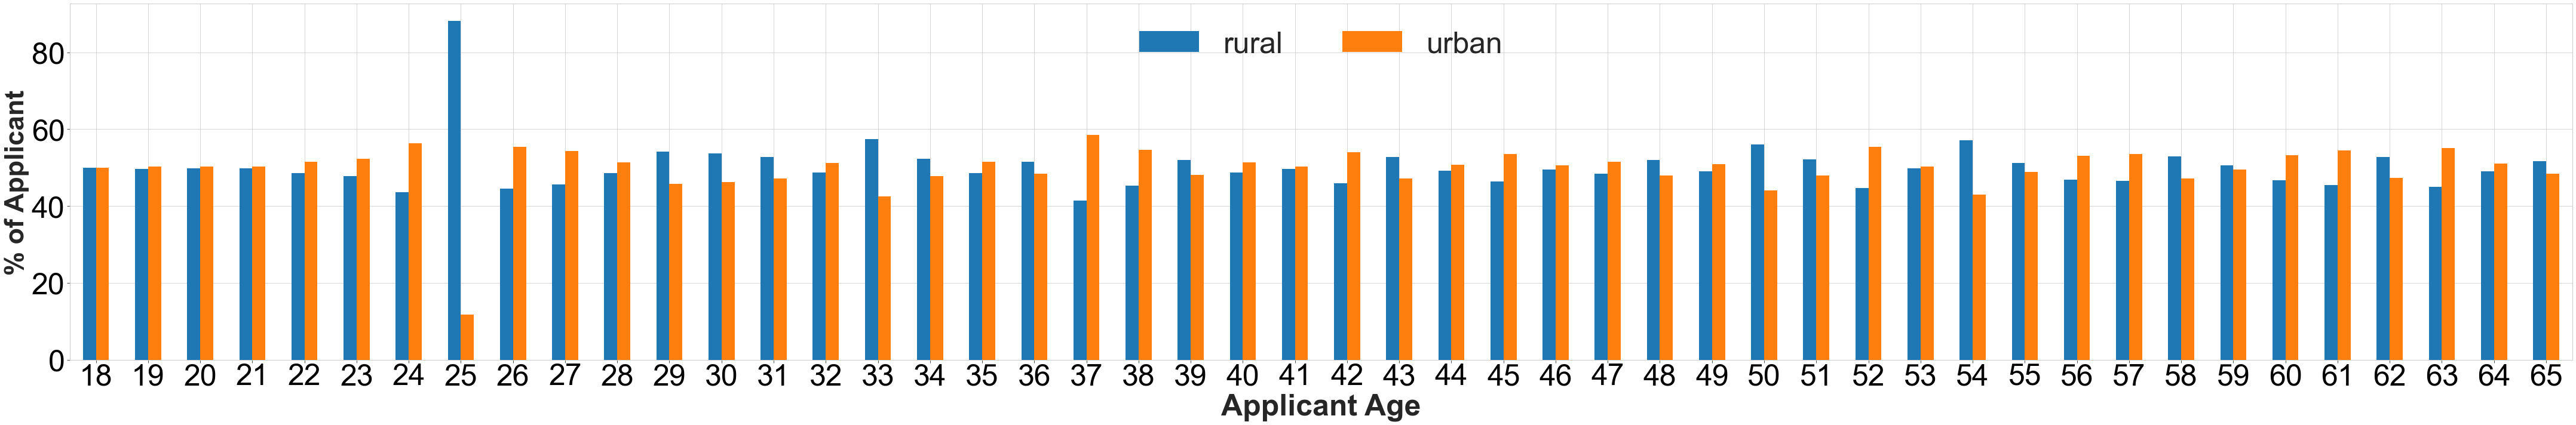

In [9]:
sql = """
select a.age, a.area, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, area, count(age) num_applicant
from oodle_data
GROUP BY age, area)a
order by 1
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='area', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/urban_vs_rural_areas_age_dist.pdf",  bbox_inches="tight")

<font size="4">The figure above shows the percentage distribution of applicants that live in either rural and urban areas. Interestingly, there are more more applicants of age 25 living in rural areas. </font>